In [ ]:
'''
import os

for file in ["pokemon_qtable.npy", "training_params.pkl", "final_state.sav"]:
    if os.path.exists(file):
        os.remove(file)
        print(f"Deleted {file}")
    else:
        print(f"{file} not found")
        #resetting
'''

In [1]:
import os
import pyboy
from pyboy import PyBoy
from pyboy.utils import WindowEvent
import numpy as np

print(os.path.exists("/home/gaur2/Downloads/Pokemon/PokemonRed.gb")) 
#os.environ["PYBOY_WINDOW_TYPE"] = "null"
rom_path = "/home/gaur2/Downloads/Pokemon/PokemonRed.gb"
pyboy = PyBoy(rom_path, window='null')

pyboy.set_emulation_speed(0)
for _ in range(3000):
    pyboy.tick()

pyboy.send_input(WindowEvent.PRESS_BUTTON_START)
for _ in range(10): pyboy.tick()
pyboy.send_input(WindowEvent.RELEASE_BUTTON_START)

pyboy.send_input(WindowEvent.PRESS_BUTTON_A)
for _ in range(10): pyboy.tick()
pyboy.send_input(WindowEvent.RELEASE_BUTTON_A)

for _ in range(200): pyboy.tick()
pyboy.send_input(WindowEvent.PRESS_BUTTON_A)
for _ in range(10): pyboy.tick()
pyboy.send_input(WindowEvent.RELEASE_BUTTON_A)


def smart_a_mash(pyboy, cycles=500):
    for _ in range(cycles):
        pyboy.send_input(WindowEvent.PRESS_BUTTON_A)
        for _ in range(2): pyboy.tick()
        pyboy.send_input(WindowEvent.RELEASE_BUTTON_A)
        for _ in range(8): pyboy.tick()
            
smart_a_mash(pyboy, cycles=371)            
for _ in range(300):
    pyboy.tick()

def smart_r_mash(pyboy, cycles=500):
    for _ in range(cycles):
        pyboy.send_input(WindowEvent.PRESS_ARROW_RIGHT)
        for _ in range(2): pyboy.tick()
        pyboy.send_input(WindowEvent.RELEASE_ARROW_RIGHT)
        for _ in range(8): pyboy.tick()

def smart_u_mash(pyboy, cycles=500):
    for _ in range(cycles):
        pyboy.send_input(WindowEvent.PRESS_ARROW_UP)
        for _ in range(2): pyboy.tick()
        pyboy.send_input(WindowEvent.RELEASE_ARROW_UP)
        for _ in range(8): pyboy.tick()

def smart_l_mash(pyboy, cycles=500):
    for _ in range(cycles):
        pyboy.send_input(WindowEvent.PRESS_ARROW_LEFT)
        for _ in range(2): pyboy.tick()
        pyboy.send_input(WindowEvent.RELEASE_ARROW_LEFT)
        for _ in range(8): pyboy.tick()

def smart_d_mash(pyboy, cycles=500):
    for _ in range(cycles):
        pyboy.send_input(WindowEvent.PRESS_ARROW_DOWN)
        for _ in range(2): pyboy.tick()
        pyboy.send_input(WindowEvent.RELEASE_ARROW_DOWN)
        for _ in range(8): pyboy.tick()

smart_r_mash(pyboy, cycles=9)
smart_u_mash(pyboy, cycles=15)
smart_r_mash(pyboy, cycles=6)
smart_d_mash(pyboy, cycles=21)
smart_l_mash(pyboy, cycles=9)
smart_d_mash(pyboy, cycles=10) #out of home
#pyboy.screen.image.show()
'''
smart_r_mash(pyboy, cycles=18)
smart_u_mash(pyboy, cycles=15)
pyboy.tick(50)
pyboy.screen.image.show() #rivals home

smart_r_mash(pyboy, cycles=10)
smart_d_mash(pyboy, cycles=10)
smart_r_mash(pyboy, cycles=8)
smart_u_mash(pyboy, cycles=6)
pyboy.tick(100)
smart_u_mash(pyboy, cycles=6)
pyboy.screen.image.show() #oaks lab

smart_r_mash(pyboy, cycles=10)
smart_u_mash(pyboy, cycles=9)
smart_r_mash(pyboy, cycles=3)
smart_u_mash(pyboy, cycles=6) # cutscene grasses
pyboy.tick(600)
smart_a_mash(pyboy, cycles=54)
#pyboy.tick(600)
#smart_a_mash(pyboy, cycles=24)
pyboy.screen.image.show()
'''
with open("pallet_town_start_new.state", "wb") as f:
    pyboy.save_state(f)
pyboy.stop()
'''
10,2 11,1
'''

True


'\n10,2 11,1\n'

In [2]:
MAX_X = 20
MAX_Y = 18
MAX_MODE = 4
MAX_MAP = 203
MAX_MOLO = 2
def get_state():
    x = pyboy.memory[0xD362]
    y = pyboy.memory[0xD361]
    map_id = pyboy.memory[0xD35E]   
    #mode = pyboy.memory[0xD057]
    #molo = pyboy.memory[0xFFD8]
    #pyboy.memory[0xD730] #& 0x01

    x = min(max(0, x), MAX_X - 1)
    y = min(max(0, y), MAX_Y - 1)

    # Return the raw map_id for accurate location tracking
    return (x, y, map_id)
print(f"Initial state: {get_state()}")
STARTER_SELECTED_ADDR = 0xD163  # chosen starter
STARTER_UNSELECTED = 0xFF     # Default value before selection
#pyboy.screen.image.show()    

Initial state: (5, 7, 0)


In [3]:
ACTIONS = ["U","D","L","R","A","B"]
ACTION_EVENTS = {
   "U" : WindowEvent.PRESS_ARROW_UP,
   "D" : WindowEvent.PRESS_ARROW_DOWN,
   "L" : WindowEvent.PRESS_ARROW_LEFT,
   "R" : WindowEvent.PRESS_ARROW_RIGHT,
   "A" : WindowEvent.PRESS_BUTTON_A,
   "B" : WindowEvent.PRESS_BUTTON_B
}

RELEASE_EVENTS = {
    "U": WindowEvent.RELEASE_ARROW_UP,
    "D": WindowEvent.RELEASE_ARROW_DOWN,
    "L": WindowEvent.RELEASE_ARROW_LEFT,
    "R": WindowEvent.RELEASE_ARROW_RIGHT,
    "A": WindowEvent.RELEASE_BUTTON_A,
    "B": WindowEvent.RELEASE_BUTTON_B
}
n = len(ACTIONS)

qtable = np.zeros((MAX_X, MAX_Y,MAX_MAP,n))
ALPHA = 0.1
GAMMA = 0.9
EPSILON =0.5

visited_tiles = set()
starter_interaction_coords = {
    # Below the table (in front of each ball)
    (4, 3), (5, 3), (6, 3),
    # Above the table
    (4, 1), (5, 1), (6, 1),
    # Left and right sides
    (3, 2), (7, 2)
}

In [4]:
def load_training_progress():
    global qtable, EPSILON, ALPHA, GAMMA
    
    try:
    
        if os.path.exists("pokemon_qtable.npy"):
            qtable = np.load("pokemon_qtable.npy")
            print("Q-table loaded successfully!")
        else:
        
            qtable = np.zeros((MAX_X, MAX_Y, MAX_MAP,n))
            print("No saved Q-table found. Starting fresh.")
        
        if os.path.exists("training_params.pkl"):
            import pickle
            with open("training_params.pkl", "rb") as f:
                training_data = pickle.load(f)
            
            start_episode = training_data['total_episodes_trained']
            print(f"Loaded training params. Starting from episode {start_episode}")
            
            return start_episode
        else:
            print("No saved training parameters. Starting fresh.")
            return 0
            
    except Exception as e:
        print(f"Error loading saved data: {e}")
        qtable = np.zeros((MAX_X, MAX_Y, MAX_MAP,n))
        return 0

start_episode = load_training_progress()
#pyboy.screen.image.show()

No saved Q-table found. Starting fresh.
No saved training parameters. Starting fresh.


In [15]:
starter_saved = False
previous_starter_value = STARTER_UNSELECTED
def reward(prev_state, new_state, action_taken):
    global starter_saved, previous_starter_value
    rew=0
    cx, cy, cmap = new_state
    px, py, pmap = prev_state
    '''
    if cmode == 2 and action_taken in ["A", "B"]:
        rew += 4.0  # text/cutscene
    elif cmode == 1 and action_taken in ["A"]:
        rew += 2.0  # battling
    elif cmode >= 3:
        rew -= 0.5
    '''
    if prev_state[0:3] == new_state[0:3] and action_taken in ["U", "D", "L", "R"]:
        rew -=0.3 #bumping walls
    
    if pmap == 0 and cmap == 0:  # Pallet Town
        oak_x, oak_y = 10,2  # oak grass position
        oak_dist = abs(cx - oak_x) + abs(cy - oak_y)
        prev_oak_dist = abs(px - oak_x) + abs(py - oak_y)
        if oak_dist < prev_oak_dist:
          rew += 0.6 + 0.1 * (prev_oak_dist - oak_dist)
        elif oak_dist > prev_oak_dist:
          rew -= 0.4 + 0.05 * (oak_dist - prev_oak_dist)
    
    if (cmap == 0) and (px, py) in [(4, 1),(5, 1),(6, 1)]:
     rew += 8.0  # Oak's cutscene

    if cmap in [40] and (cx, cy) in [(4, 7)]:
     rew += 8.0 #oaks lab
        
    if not starter_saved and cmap == 40:
        current_starter = pyboy.memory[STARTER_SELECTED_ADDR]
        if (previous_starter_value == STARTER_UNSELECTED and
            current_starter  != STARTER_UNSELECTED):
            rew += 15.0
            starter_saved = True
    previous_starter_value = pyboy.memory[STARTER_SELECTED_ADDR]
    
    if cmap in [37,38]:  # Home penalties
      rew -= 2.0 
    if pmap in [37,38] and cmap in [37,38] and action_taken in ["A", "B"]:
      rew -= 0.5
    if (cx, cy, cmap) in [(5,6,0),(5,7,0), (6,6,0), (6,7,0)]:
      rew -= 0.3 # near-home penalty   
        
    if new_state != prev_state: #movement
        rew +=0.2

    if pmap == 0 and cmap in [40]:  # Transitioned to lab
        rew += 8.0
        
    if action_taken in ["A", "B"]:
      rew -= 0.8 # Flat penalty for spamming

    state_key = (cx, cy, cmap)  # Ignore mode for exploration
    if state_key not in visited_tiles:
        visited_tiles.add(state_key)
        rew += 0.4
    else:
        rew -= 0.2  # Minor penalty for revisiting
    return rew

In [ ]:
'''
with open("starter.state", "rb") as f:
    pyboy.load_state(f)

starter = pyboy.memory[0xD16F]
print("Starter value:", hex(starter))
#starter is picked confirmation
'''

In [17]:
episode_rewards = []
pyboy = PyBoy(rom_path, window='null')
for episode in range(5000):
   milestone_cutscene_triggered = False
   milestone_lab_reached = False
   starter_saved = False
   visited_tiles = set()
   totalr=0
   with open("pallet_town_start_new.state", "rb") as f:
        pyboy.load_state(f)
   state = get_state()
   total_reward = 0 
   done = False
   steps =0
   print(f"Episode {episode}: Starting at {state}")
   while not done:
    if np.random.random()<EPSILON:
        action = np.random.randint(0,n)
    else:
        action = np.argmax(qtable[state])
        
    actionkey = ACTIONS[action]
       
    pyboy.send_input(ACTION_EVENTS[actionkey])
    pyboy.tick(8)
    pyboy.send_input(RELEASE_EVENTS[actionkey])
    pyboy.tick(16)
       
    new = get_state()
    r = reward(state,new,actionkey)

    totalr+= r
    if steps % 100 == 0:
     print(f"State: {state}, Action: {actionkey}, Reward: {r:.2f}, Total: {totalr:.2f}")
 
    cx, cy, cmap = new
    px, py, pmap = state

# --- Oak's Cutscene Milestone ---
    if (not milestone_cutscene_triggered and cmap == 0):
     milestone_cutscene_triggered = True
     with open("oakcutscene.state", "wb") as f:
        pyboy.save_state(f)
     np.save("qtable_oakcutscene.npy", qtable)
     pyboy.screen.image.save(f"oak_cutscene_{episode}.png")
     print("[MILESTONE] Triggered Oak's cutscene — saved state and Q-table")

# --- Reached Oak's Lab after Cutscene ---
    if (milestone_cutscene_triggered and not milestone_lab_reached and
     cmap == 40):
     milestone_lab_reached = True
     with open("oaklab.state", "wb") as f:
        pyboy.save_state(f)
     np.save("qtable_oaklab.npy", qtable)
     pyboy.screen.image.save(f"oak_lab_{episode}.png")
     print("[MILESTONE] Reached Oak's lab — saved state and Q-table")

# --- Starter Selection ---
    if (not starter_saved and cmap == 40 and 
    (cx, cy) in starter_interaction_coords):
     current_starter = pyboy.memory[STARTER_SELECTED_ADDR]
     if current_starter != STARTER_UNSELECTED:
        starter_saved = True
        with open("starter.state", "wb") as f:
            pyboy.save_state(f)
        np.save("qtable_starter.npy", qtable)
        pyboy.screen.image.save(f"starter_{episode}.png")
        print("[MILESTONE] Chosen starter — saved state and Q-table")

    x, y, map_id = state
    nx, ny, nmap_id = new

    oldq = qtable[x, y, map_id,action]
    nextq = np.max(qtable[nx, ny, nmap_id])
    newq = oldq + ALPHA * (r + GAMMA * nextq - oldq)
    qtable[x, y, map_id,action] = newq
    steps += 1
    state = new

    if steps >= 2000:  
        done = True
        print(f"episode {episode}: TIMEOUT at {state}")
   EPSILON = max(0.15, EPSILON*0.9998)
   episode_rewards.append(totalr) 
   if episode%20==0: 
    pyboy.screen.image.show() 

Episode 0: Starting at (5, 7, 0)
State: (5, 7, 0), Action: L, Reward: 0.15, Total: 0.15
[MILESTONE] Triggered Oak's cutscene — saved state and Q-table
State: (1, 2, 37), Action: D, Reward: -2.00, Total: -110.25
State: (5, 1, 37), Action: D, Reward: -2.00, Total: -335.95
State: (4, 6, 38), Action: U, Reward: -2.00, Total: -574.35
State: (3, 6, 38), Action: D, Reward: -2.50, Total: -818.75
State: (5, 2, 38), Action: U, Reward: -2.00, Total: -1055.25
State: (4, 5, 38), Action: R, Reward: -2.00, Total: -1298.25
State: (3, 7, 38), Action: U, Reward: -2.00, Total: -1542.15
State: (1, 2, 38), Action: A, Reward: -3.50, Total: -1797.15
State: (6, 2, 37), Action: L, Reward: -2.00, Total: -2049.95
State: (7, 6, 0), Action: L, Reward: -0.75, Total: -2253.40
State: (9, 9, 0), Action: U, Reward: 0.15, Total: -2277.35
[MILESTONE] Reached Oak's lab — saved state and Q-table
[MILESTONE] Chosen starter — saved state and Q-table
State: (5, 3, 40), Action: D, Reward: -0.50, Total: -2319.55
State: (5, 3, 4

KeyboardInterrupt: 

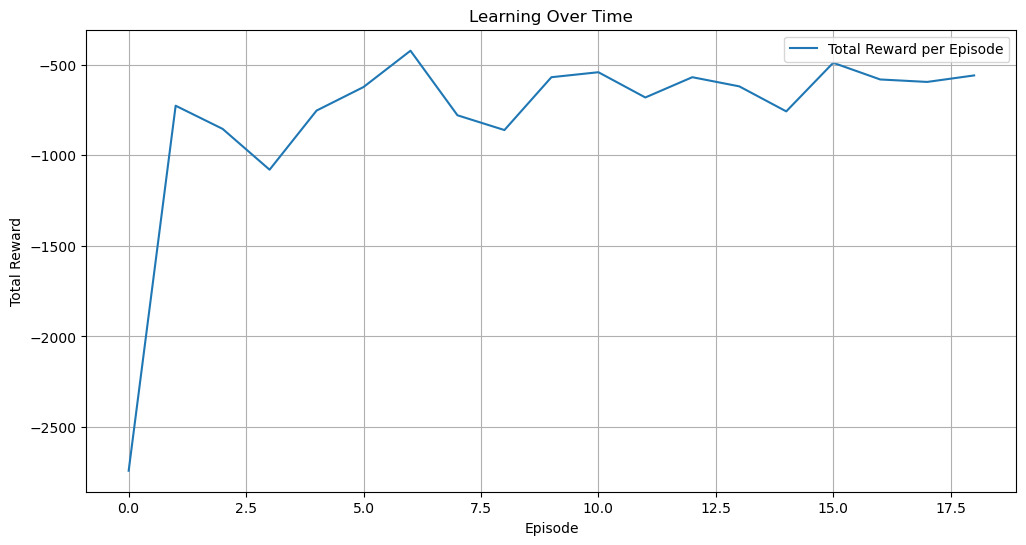

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(episode_rewards, label="Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Learning Over Time")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:

def save_training_progress():
    np.save("pokemon_qtable.npy", qtable)
    
    training_data = {
        'episode_count': episode, 
        'total_episodes_trained': episode + 1,
        'alpha': ALPHA,
        'gamma': GAMMA
    }
    
    import pickle
    with open("training_params.pkl", "wb") as f:
        pickle.dump(training_data, f)
    
    with open("final_state.sav", "wb") as f:
        pyboy.save_state(f)
    
    print(f"Training saved! Completed {episode + 1} episodes")

save_training_progress()
